Vercel has a limit on the memory on the server. The bottleneck for me is sklearn. So to go around this, I'm creating from-scratch implementations of TFIDF and linear regression :-)

In [1]:
import pandas as pd
import numpy as np
# can still use the evaluation stuff for now haha
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pickle

<AxesSubplot:ylabel='Frequency'>

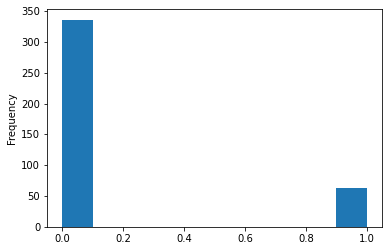

In [2]:

# load the dataset
df = pd.read_excel('Tabs Dataset.xlsx', sheet_name='Sheet2')

df['tab_name'] = df['url_and_tab_name'].apply(lambda x: x.split(' | ')[1])
df['on_topic'].fillna(0, inplace=True)
df['on_topic'].plot.hist()

This is a pretty imbalanced problem! I am not focusing much :-)

In [3]:
# Now for the from scratch implementation. I would not advice copilot or chatgpt here as it
# defeats the point, and they are also not perfect!

# Instead, follow tutorials like https://www.kaggle.com/code/yassinehamdaoui1/creating-tf-idf-model-from-scratch

class TFIDF:
    def __init__(self):
        self.documents = None
        self.vocab = None
        self.idf = None
        self.tf = None
        self.tfidf = None

    def fit(self, documents):
        self.documents = documents
        self.vocab = list(set([word for doc in documents for word in doc.split()]))
        self.idf = np.zeros(len(self.vocab))
        self.tf = np.zeros((len(self.documents), len(self.vocab)))
        self.tfidf = np.zeros((len(self.documents), len(self.vocab)))
        for i, doc in enumerate(self.documents):
            for j, word in enumerate(self.vocab):
                self.tf[i, j] = doc.split().count(word) / len(doc.split())
                if self.tf[i, j] > 0:
                    self.idf[j] += 1
        self.idf = np.log(len(self.documents) / self.idf)
        self.tfidf = self.tf * self.idf
    
    def transform(self, documents):
        tfidf = np.zeros((len(documents), len(self.vocab)))
        for i, doc in enumerate(documents):
            for j, word in enumerate(self.vocab):
                tfidf[i, j] = doc.split().count(word) / len(doc.split()) * self.idf[j]
        return tfidf
    
    def fit_transform(self, documents):
        self.fit(documents)
        return self.tfidf
    
    def save_model(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)
        
    def load_model(self, path):
        with open(path, 'rb') as f:
            self = pickle.load(f)
        return self
    

In [4]:

# test the data
tfidf = TFIDF()
tfidf.fit(df['tab_name'].values)

tfidf.save_model('api/storage/tfidf.pkl')
tfidf = TFIDF()

tfidf = tfidf.load_model('api/storage/tfidf.pkl')

X = tfidf.transform(df['tab_name'].values)


This worked, but as we can see, it leaves many more columns than data points in an already unbalanced dataset! 

To resolve, let's use L1 regularization on top of logistic regression.

Alternatively, we can use feature engineering to further refine the word counting above to only include alphabetic characters, try different tokenizers, etc.

In [5]:



class LogisticRegression:
    
    def __init__(self, learning_rate=0.01, n_iters=5000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        # initialize weights and bias to zeros
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # gradient descent optimization
        for i in range(self.n_iters):
            # calculate predicted probabilities and cost
            z = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(z)
            cost = (-1 / n_samples) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            
            # calculate gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))            
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            # update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
    def predict(self, X,probabilities=False):
        # calculate predicted probabilities
        z = np.dot(X, self.weights) + self.bias
        y_pred = self._sigmoid(z)
        if probabilities:
            return y_pred
        
        # convert probabilities to binary predictions
        return np.round(y_pred).astype(int)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def save_model(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

    def load_model(self, path):
        with open(path, 'rb') as f:
            self = pickle.load(f)
        return self
    



In [6]:

# initialize logistic regression model
lr = LogisticRegression()
y = df['on_topic'].values
# train model on sample dataset
lr.fit(X, y)


In [7]:
predictions = lr.predict(X,probabilities=True)



(0.0, 1.0)

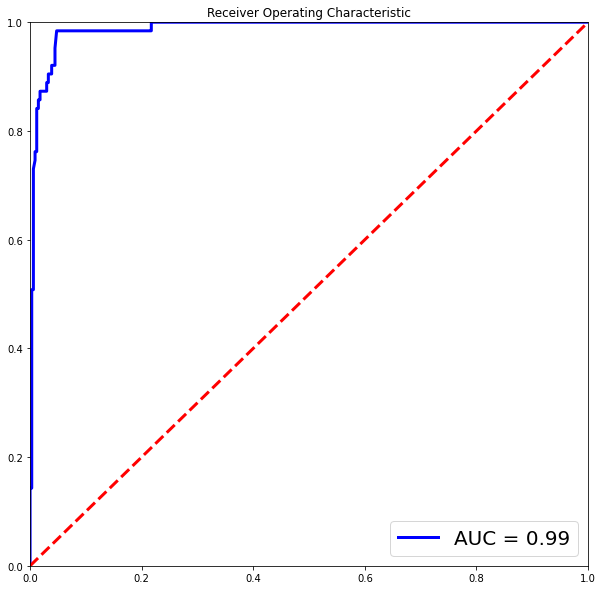

In [8]:
# plot auc of predictions 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, thresholds = roc_curve(y, predictions)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,linewidth=3)
plt.legend(loc = 'lower right',fontsize=20)
plt.plot([0, 1], [0, 1],'r--',linewidth=3)
plt.xlim([0, 1])
plt.ylim([0, 1])


Before we get too thrilled with this result, two important caveats:

1. This is training data! The model is overfitting and this is not especially impressive.
2. This dataset is highly imbalanced. As a result, AUC is no longer a great metric, seeing as most of this data is class 0 to begin with. 


Regardless, I'm pushing ahead. The result above indicates to me that a threshold <0.5 will be best, and my judgement says that in order to keep somewhat lax, I'll make the threshold especially low, to be .1. By doing this we'll now see some predictions below, and the model will be somewhat capable of predicting if a tab title is "relevant" or not. 

In [9]:
thresh = 0.15
from sklearn.metrics import precision_score, recall_score
predictions = [1 if x > thresh else 0 for x in predictions]
precision = precision_score(y, predictions)
recall = recall_score(y, predictions)

print('Precision: {} / Recall: {}'.format(round(precision, 3), round(recall, 3)))

accuracy = accuracy_score(y, predictions)
print('Accuracy: {}'.format(round(accuracy, 3)))

df['predictions'] = predictions

Precision: 0.333 / Recall: 1.0
Accuracy: 0.684


In [ ]:
df[df['predictions'] == 1].sample(n=3)

All of these predictions look about right! If these were the tabs I was on, I'd be happy and think I was doing productive work. 

How about the alternative?

In [ ]:
df[df['predictions'] == 0].sample(n=3)

Again, about same. Not as many of these pages are productive.

Lastly, we save the model and confirm it retains the weights & biases used in training.

In [10]:
init_weights = lr.weights

# save model 

lr.save_model('api/storage/model.pkl')
lr = LogisticRegression()

lr = lr.load_model('api/storage/model.pkl')

assert np.allclose(init_weights, lr.weights)



In [12]:
lr.predict(tfidf.transform(['how to be a better data scientist']),probabilities=True)

# this is on topic! Good!

array([0.1868542])